In [1]:
# Setup for publishing 3D plotly charts so they can be shown on the website blog page
import chart_studio
import os
from dotenv import load_dotenv
load_dotenv()
username = os.getenv("username") # your username
api_key = os.getenv("api_key") # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

## Create some fake data

We'll start this example by creating some fake data. To keep things simple,
we'll create data with three features that we can plot on a 3D scatterplot,
and we'll transform this data into 2D UMAPs. Because we can visualise both
the original and the transformed data, it will be easier to understand what's
going on.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import umap

plt.rcParams["font.size"] = 14

# Use this line to set a seed so this is reproducible
prng = np.random.default_rng(seed=42)

# Create a colour map 
colourmap={'a': '#636EFA', 'b': '#EF553B', 'c': '#00CC96', 'd': '#9e42f5'}

In [3]:
num_pts_per_cluster = 1000

# Define the coordinates for the means of each cluster and their covariance
# matrices
cluster_means = dict(zip("abcd", [
    (10, 10, 17),
    (12, 6, 10), 
    (5, 10, 8), 
    (12, 15, 10)]))
cluster_covs = dict(zip("abcd", [
    [[10, 0, 0], [0, 12, 0], [0, 0, 4]],
    [[1, 0, 0],  [0, 1, 0],  [0, 0, 1]], 
    [[10, 0, 0], [0, 8, 0],  [0, 0, 5]], 
    [[2, 0, 0],  [0, 2, 0],  [0, 0, 6]]
]))

original_data_list = []
for cluster in "abcd":
    df = pd.DataFrame(
            prng.multivariate_normal(
                mean=cluster_means[cluster], 
                cov=cluster_covs[cluster], 
                size=num_pts_per_cluster)
            )
    df["cluster"] = cluster
    original_data_list.append(df)

original_data = pd.concat(original_data_list, axis=0)
original_data.columns = ['x', 'y', 'z', 'cluster']
original_data = original_data.reset_index(drop=True)
original_data["id"] = original_data.index # add an ID column

In [4]:
original_data

,x,y,z,cluster,id
0,6.711281,11.055571,18.500902,a,0
1,3.830285,13.258212,14.395641,a,1
2,8.999953,10.442852,16.966398,a,2
3,12.780901,7.044969,18.555584,a,3
4,13.564650,10.228737,17.935019,a,4
...,...,...,...,...,...
3995,10.171605,15.432086,9.361099,d,3995
3996,11.794408,14.573967,7.287882,d,3996
3997,11.409480,16.116730,7.241985,d,3997
3998,11.817696,15.399740,8.966762,d,3998


In [7]:
fig = px.scatter_3d(original_data, x='x', y='y', z='z', color='cluster',
                    color_discrete_map=colourmap,
)
fig.update_traces(marker={'size': 2, 'opacity':0.5})
fig.update_layout(legend= {'itemsizing': 'constant'})

chart_studio.plotly.plot(fig, filename='DR_blog_Nov2022_fig1')
fig

# UMAP is not inherently reproducible

There are several levels of reproducibility we can discuss here. Anyone who has
done some work with UMAP will probably know that if you run it twice, you'll get
a slightly different-looking output, unless you set the random state or 'seed'.

To demonstrate this, we'll create four UMAPS from the data defined above.

1. The initial UMAP, with a seed set
2. Re-run the UMAP with the same seed
3. Re-run the UMAP with a different seed
4. Re-run the UMAP with the same seed, but shuffle the input data

In [10]:
def run_umap(data, random_state):
    reducer = umap.UMAP(random_state=random_state, n_neighbors=30, n_components=2)
    embedding = reducer.fit_transform(data.drop(columns=['cluster', 'id']))

    result = pd.concat(
        [data, 
        pd.DataFrame(embedding, columns=("umap_0", "umap_1"))], 
        axis=1)

    return result

In [11]:
# Create an initial umap
initial_umap = run_umap(original_data, 42)

# Re-create the umap with the same seed
same_seed = run_umap(original_data, 42)

# Re-create the umap with a different seed
different_seed = run_umap(original_data, 4422)

# Recreate the umap with the same seed, but shuffle the input data
shuffled_data = original_data.sample(frac=1, random_state=prng).reset_index(drop=True)
same_seed_shuffled = run_umap(shuffled_data, 42)

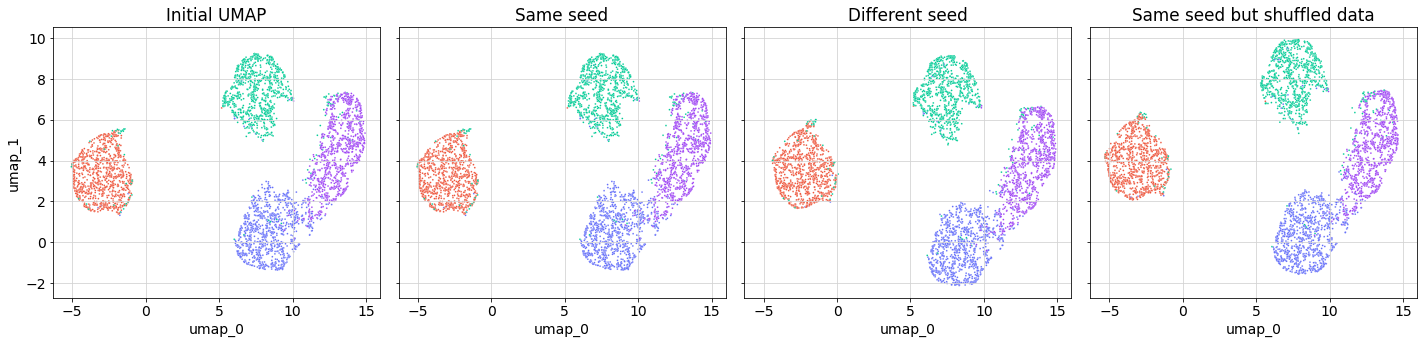

In [12]:
umaps = [initial_umap, same_seed, different_seed, same_seed_shuffled]
descriptions = ["Initial UMAP", "Same seed", "Different seed", "Same seed but shuffled data"]

fig, axs = plt.subplots(1, 4, figsize=(20,5), sharex=True, sharey=True)
for i, ax in enumerate(axs):
    sns.scatterplot(data=umaps[i], x="umap_0", y="umap_1", hue="cluster", ax = ax, s=3, legend=False, palette=colourmap)
    ax.set_title(descriptions[i])
    ax.grid(visible=True, color="lightgrey")

plt.tight_layout()

It's probably not a huge surprise that if you run a UMAP twice on the same
data using the same seed you get an identical result, and that if you use a
different seed you get a slightly different result.

What's probably less well-known is that setting the seed only allows for
reproducibility if the data is exactly the same. If you were running the UMAP
with only a subset of the data, or even with exactly the same data but
*in a different order*, you'll get a slightly different result. This is shown
in the right-hand panel of the figure above. The shape of the UMAP looks
very similar to the the left-hand panel, but it's not identical (notably the
green cluster is at a higher position on the y-axis).

## Are all the points in the same clusters?

It's worth taking a look at where each data point between one UMAP and another.
In this case let's look at the difference between the initial UMAP (left-hand panel)
and the UMAP made with the same seed but with shuffled data (right-hand panel).

In [13]:
# Create a dataframe with umap coordinates from both transformations, and join
# using the ID.

df = pd.merge(
    initial_umap,
    same_seed_shuffled.loc[:, ['id', 'umap_0', 'umap_1']],
    on = 'id', 
    suffixes=('_first', '_second')
)

# Calculate the euclidean distance between the first and second UMAP coordinates
df['eucl_dist'] = np.sqrt(
    (df.umap_0_first - df.umap_0_second)**2 
    + (df.umap_1_first - df.umap_1_second)**2)

The euclidean distances between the first and second UMAP coordinates are
mostly quite small, but there are some points that appear to have moved quite
a lot.

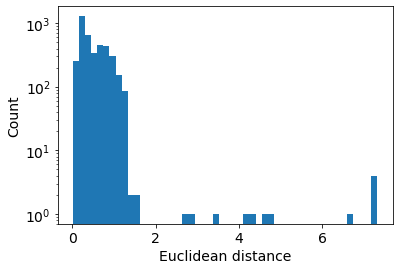

In [14]:
df['eucl_dist'].hist(bins=50, grid=False, log=True)
plt.xlabel("Euclidean distance")
plt.ylabel("Count")
plt.show()

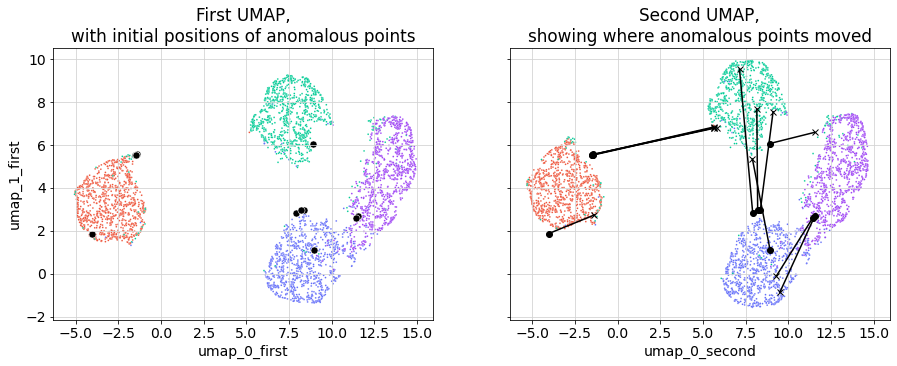

In [15]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharex=True, sharey=True)

sns.scatterplot(data=df, x="umap_0_first", y="umap_1_first", hue="cluster", palette=colourmap, s=3, ax=axs[0], legend=False)
sns.scatterplot(data=df, x="umap_0_second", y="umap_1_second", hue="cluster", palette=colourmap, s=3, ax=axs[1], legend=False)

axs[0].grid(visible=True, color="lightgrey")
axs[1].grid(visible=True, color="lightgrey")

df_anomalous = df[df['eucl_dist'] > 2]

sns.scatterplot(data=df_anomalous, x="umap_0_first", y="umap_1_first", color="black", s=50, ax=axs[0], legend=False)

def plot_connecting_line(ax, x1, x2, y1, y2):
    ax.plot(x1, y1, color='k', marker='o')
    ax.plot(x2, y2, color='k', marker='x')
    ax.plot([x1, x2], [y1, y2], color='k', marker=None)

for i in df_anomalous.index:
        
    plot_connecting_line(axs[1],
        x1 = df_anomalous.loc[i, 'umap_0_first'],
        x2 = df_anomalous.loc[i, 'umap_0_second'],
        y1 = df_anomalous.loc[i, 'umap_1_first'],
        y2 = df_anomalous.loc[i, 'umap_1_second'])

axs[0].set_title("First UMAP,\nwith initial positions of anomalous points")
axs[1].set_title("Second UMAP,\nshowing where anomalous points moved")
plt.show()

Let's take a look at where these points were in the original, 3-dimensional data:

In [16]:
fig = px.scatter_3d(initial_umap, x='x', y='y', z='z', color='cluster',
                    color_discrete_map={'a': '#636EFA', 'b': '#EF553B', 'c': '#00CC96'},
)
fig.update_traces(marker={'size': 2, 'opacity':0.5})

anomalous_points = px.scatter_3d(df_anomalous,  x='x', y='y', z='z')
anomalous_points.update_traces(marker={'size': 5, 'opacity':0.5, 'color': 'black'})

fig = go.Figure(data=fig.data + anomalous_points.data)
fig.update_layout(legend={'itemsizing': 'constant'})

chart_studio.plotly.plot(fig, filename='DR_blog_Nov2022_fig5')
fig

As you might have guessed, these points were all ambiguous as to which cluster they should belong to in the original 3D space. They fell generally between the clusters. The stochasticity of the algorithm will sometimes place them in one cluster, and sometimes in another.

# References

To learn more I'd highly reccommend the following sources:
* UMAP documentation from skikit-learn (https://umap-learn.readthedocs.io/en/latest/index.html).
* The github page for the python implementation of umap (https://github.com/lmcinnes/umap)
* The github page for the R implementation of umap (uwot) (https://github.com/jlmelville/uwot)
